## Making Experts

#### Using the Yelp data we've cleaned and wrangled, we're going to explore if we can create a feature where some users are considered 'experts' and from there if there would be a market for this amongst businesses.  

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('yelp_merged_data.csv', index_col=0, dtype={37:str, 38:str}, encoding='iso-8859-1')
pd.set_option('display.max_columns', 1300)

C:\Users\Reilly Proudsworth\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
print(df.shape)
df.head(n=3)

(994208, 1244)


,business_id,date,stars_user,user_id,average_stars,compliment_cool,compliment_cute,compliment_funny,compliment_hot,compliment_list,compliment_more,compliment_note,compliment_photos,compliment_plain,compliment_profile,compliment_writer,cool,elite,fans,friends,funny,name_user,review_count_user,type_user,useful,yelping_since,index,address,attributes,categories,city,hours,is_open,latitude,longitude,name_bus,neighborhood,postal_code,review_count_bus,stars_bus,state,type_bus,Environmental Testing,IV Hydration,Art Restoration,Backshop,Pulmonologist,Workers Compensation Law,Dentists,Tennis,Czech,LAN Centers,Caribbean,Public Transportation,Cannabis Tours,Linens,Beer,Market Stalls,Duty-Free Shops,Leisure Centers,3D Printing,Town Car Service,Club Crawl,Midwives,Powder Coating,First Aid Classes,Street Art,Party Bus Rentals,Periodontists,Gymnastics,Cosmetic Surgeons,Embroidery & Crochet,Korean,Breakfast & Brunch,Cosmetology Schools,Gas & Service Stations,Internal Medicine,Golf Equipment,Shoe Shine,Waxing,Banks & Credit Unions,Seafood Markets,Storefront Clinics,Casinos,Watches,Childbirth Education,Auto Detailing,Soul Food,Surgeons,Flooring,Vehicle Shipping,Laboratory Testing,Horse Boarding,Orthopedists,Prosthodontists,Rest Stops,Scavenger Hunts,Christmas Markets,Nightlife,Filipino,Water Delivery,Tanning,Printing Services,Carpet Installation,Skating Rinks,Family Practice,Party Bike Rentals,Burgers,Acne Treatment,Popcorn Shops,Tutoring Centers,Bagels,DJs,Bespoke Clothing,Dental Hygienists,Ophthalmologists,Solar Installation,Editorial Services,Outlet Stores,Oriental,Recording & Rehearsal Studios,Auto Repair,Smog Check Stations,Auto Upholstery,Blood & Plasma Donation Centers,Scooter Tours,Fireworks,Lingerie,Candy Stores,Piercing,Cards & Stationery,Private Jet Charter,Lounges,Ukrainian,Caricatures,Greek,Party Equipment Rentals,Pedicabs,Karate,Boxing,Sandwiches,Home Services,Themed Cafes,Music & Video,Car Rental,Permanent Makeup,Fashion,Auto Glass Services,Moroccan,Comic Books,Scottish,Water Stores,Car Buyers,Trusts,Halotherapy,Beer Gardens,Pop-Up Restaurants,Roofing,Fabric Stores,Tex-Mex,Meditation Centers,Food Delivery Services,Bail Bondsmen,Medical Law,Rugs,Car Wash,Transmission Repair,Circuit Training Gyms,Gyms,Gardeners,Argentine,Animal Physical Therapy,Community Gardens,Animal Shelters,Ayurveda,Apartments,Magicians,Food Banks,Legal Services,Beach Bars,Hydro-jetting,Yelp Events,Structural Engineers,Barbers,Cafes,Check Cashing/Pay-day Loans,Airports,Carpeting,Propane,Donairs,Junk Removal & Hauling,Medical Cannabis Referrals,Attraction Farms,Bookbinding,Spin Classes,Parent Cafes,Stucco Services,Homeowner Association,Ski Schools,Psychics & Astrologers,Bike Rentals,Libraries,Framing,Employment Law,Orthotics,Coffee Roasteries,Endodontists,Public Relations,Neurotologists,Delis,Pet Training,Pediatric Dentists,Arts & Crafts,Auction Houses,Delicatessen,Tours,Laser Hair Removal,CSA,Oncologist,Tapas Bars,Henna Artists,Cultural Center,Fruits & Veggies,Wholesale Stores,Used,ATV Rentals/Tours,Izakaya,Shoe Stores,Pet Breeders,Lawyers,Painters,Churches,Dominican,Clothing Rental,Food Court,Spine Surgeons,Rotisserie Chicken,Bowling,Ranches,Bars,Mountain Biking,Bike Sharing,Pool Cleaners,Security Services,French,Valet Services,Chocolatiers & Shops,Alsatian,Egyptian,Shared Office Spaces,Rheumatologists,Flatbread,Horse Equipment Shops,Mexican,Sports Medicine,Officiants,Guitar Stores,Taxidermy,Uniforms,Vegetarian,Drugstores,Dance Studios,Fitness/Exercise Equipment,Assisted Living Facilities,General Dentistry,Fondue,Chicken Shop,Photographers,Talent Agencies,Bookstores,Zoos,Doulas,Baby Gear & Furniture,Baden,Go Karts,Cideries,Session Photography,Ethic Grocery,Real Estate Services,Cooking Classes,Badminton,Day Spas,Bed & Breakfast,Acupuncture,Diagnostic Imaging,Arcades,Wheel & Rim Repair,Junkyards,Obstetricians & Gynecologists,Music Production Services,Religious Items,Emergency Medicine,Tickets,Restaurant Supplies,Bistros,House Sitters,Pawn Shops,Colombian,Canadian

In [4]:
small_df = df[['business_id', 'date', 'stars_user', 'user_id', 'review_count_user', 'city', 'name_bus', 'stars_bus', 'Restaurants', 'Mexican', 'Indian']].copy()

In [96]:
food_df = small_df[df['Mexican'] == 1]
food_df = food_df[food_df['city'] == 'Las Vegas']
food_review_count = food_df.groupby('user_id', as_index=False).size().reset_index(name='category_review_count')
food_df = food_df.merge(food_review_count, on='user_id')
##Based on the number of average reviews for a particular type, user must be above statistically significant metric
user_genre_reviews = food_df.drop_duplicates(subset='user_id')
user_genre_reviews.shape

(9810, 12)

#### From these numbers we can see there are a significant number of reviews for one genre of food in one city.  Actually about 1% of the total reviews are for this genre of food!

1     8769
2      704
3      167
4       74
5       41
6       29
7        7
8        6
9        1
10       4
11       2
12       2
13       1
14       1
15       1
16       0
17       0
18       0
19       0
20       0
21       0
22       0
23       0
24       0
25       0
26       1
Name: category_review_count, dtype: int64


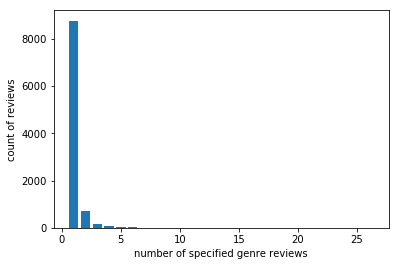

In [97]:
review_counts = user_genre_reviews['category_review_count'].value_counts()
review_counts = review_counts.reindex(np.arange(1, max(user_genre_reviews['category_review_count']) + 1), fill_value=0)
print(review_counts)
plt.bar(np.arange(1, len(review_counts) + 1), review_counts.values)
plt.xlabel('number of specified genre reviews')
plt.ylabel('count of reviews')
plt.show()

#### It turns out that there is a distribution of these reviews which drops off significantly after people leave one review.

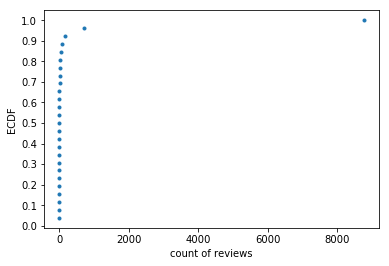

In [98]:
x = review_counts.sort_values()
n = len(review_counts)
y = np.arange(1, n + 1) / n
plt.plot(x, y, marker='.', linestyle='none')
plt.xlabel('count of reviews')
plt.ylabel('ECDF')
plt.yticks(np.linspace(0, 1, 11))
plt.show()

#### This cumulative distribution shows that about 90% of the total reviews for this genre are by users who left 3 reviews or less.

In [99]:
review_sum = review_counts.sum()
expert_threshold = 0.99 * review_sum
threshold = 0
expert_index=1
while threshold <= expert_threshold:
    threshold = threshold + review_counts[expert_index]
    expert_index = expert_index + 1

expert_index

5

#### By setting a threshold of 99%, this shows our experts start at users who review 5 or more Mexican restaurants in Las Vegas.

In [116]:
experts_df.head()

,business_id,date,stars_user,user_id,review_count_user,city,name_bus,stars_bus,Restaurants,Mexican,Indian,category_review_count
38,4I4OoW0tbaoG4I4D2spF3w,2011-04-26,3,FIk4lQQu1eTe2EpzQ4xhBA,841,Las Vegas,Del Taco,3.0,1.0,1.0,0.0,7
39,fnZrZlqW1Z8iWgTVDfv_MA,2010-10-18,5,FIk4lQQu1eTe2EpzQ4xhBA,841,Las Vegas,Carl's Jr,2.5,1.0,1.0,0.0,7
40,WyZAeMGsjUE7OToI4Jdqfw,2011-02-07,4,FIk4lQQu1eTe2EpzQ4xhBA,841,Las Vegas,Chipotle Mexican Grill,3.5,1.0,1.0,0.0,7
41,CVECSCW-7zDzjpIPxsew4g,2012-10-03,4,FIk4lQQu1eTe2EpzQ4xhBA,841,Las Vegas,Tacos El Compita,4.5,1.0,1.0,0.0,7
42,lINk_EU_elY6iTrfUGcRqg,2012-03-29,4,FIk4lQQu1eTe2EpzQ4xhBA,841,Las Vegas,El Pollo Loco,2.0,1.0,1.0,0.0,7


In [108]:
expert_df = food_df[food_df['category_review_count'] >= expert_index]
expert_df = expert_df[['business_id', 'stars_user', 'stars_bus']]
avg_compare_df = expert_df.groupby('business_id', as_index=False).mean()
##food_df = food_df.merge(food_review_count, on='user_id')

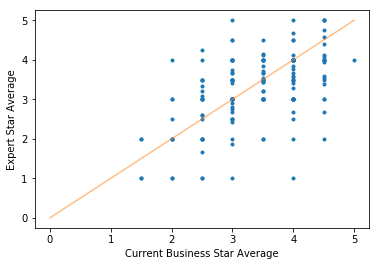

In [119]:
x = avg_compare_df['stars_bus']
y = avg_compare_df['stars_user']
plt.plot(x, y, marker='.', linestyle='none')
x45 = [0, 5]
y45 = [0, 5]
plt.plot(x45, y45, alpha=0.5)
plt.xlabel('Current Business Star Average')
plt.ylabel('Expert Star Average')
plt.show()

#### By using the 45 degree line, this plot makes it apparent some businesses have much higher 'expert' ratings than average user ratings.  Any of the points above the red line would benefit from this service.  We definitely have a market for this feature!